### Customer segmentation with online retail transactions

After taking the Datacamp course "Customer segmentation in Python", I decided to practice what I learned using the online retail dataset from UCI machine learning repository. The dataset contains information about transactions for a UK-based online retail. The following is an overview of the analyses I did:
#### 1. Cohort analysis of retention rate
#### 2. Computation of recency (R), frequency (F), and monetary value (M) and tenure
#### 3. K-means clustering to segment customers using RFM values and tenure

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('ecommerce.csv', encoding="ISO-8859-1")

In [3]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


#### Data cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# check and drop missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df.dropna(axis=0, how='any', inplace=True)

In [7]:
# check and drop duplicated rows
df.duplicated().sum()

5225

In [8]:
df = df.drop_duplicates()

In [9]:
# change data type for some columns
df['CustomerID'] = df['CustomerID'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [10]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


Negative values for quantity and 0 for UnitPrice don't look right. It turns out negative values of Quantity indicate cancelled orders - InvoiceNo starts with a 'C' for these transactions. It's not clear why price might be 0 for some transactions, but these are removed to ensure all purchases have >0 monetary value.   

In [11]:
# remove cancelled orders (with a negative quantity) and orders with unit price of 0
df = df[(df['Quantity']>0) & (df['UnitPrice']!=0)]

In [12]:
# print information about transactions
print('Dataframe contains {} observations.'.format(len(df)))
print('{} unique transactions, {} unique products, and {} unique customers.'.format(df['InvoiceNo'].nunique(), 
                                                                                   df['StockCode'].nunique(),
                                                                                   df['CustomerID'].nunique()))
print('Transactions are made from {} to {}.'.format(min(df['InvoiceDate']), max(df['InvoiceDate'])))

Dataframe contains 392692 observations.
18532 unique transactions, 3665 unique products, and 4338 unique customers.
Transactions are made from 2010-12-01 08:26:00 to 2011-12-09 12:50:00.


#### Cohort analysis
Cohort analysis is a straightforward way to look at customers in different segments/cohorts. Here I explore retention rate as a function of time cohorts - time during which customers are first acquired and time since first acquisition.

Create a column CohortMonth: month during with a customer is acquired/first makes a purchase

In [13]:
# function to get month from a datetime, use 1st as day
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

In [14]:
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')

In [15]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01


Create MonthSinceAcq: number of month since a customer's first purchase

In [16]:
# function to extract interger number of year, month, and day from a date
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [17]:
invoice_year, invoice_month, _ = get_date_int(df, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(df, 'CohortMonth')

# calculate month since a customer's first purchase
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
df['MonthSinceAcq'] = years_diff * 12 + months_diff + 1 # +1 so first month since acquisition would be 1

In [18]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,MonthSinceAcq
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1


Get monthly active customers as a function of cohort of acquisition and months since acquisition

In [19]:
cohort = df.groupby(['CohortMonth', 'MonthSinceAcq'])['CustomerID'].nunique()
cohort = cohort.reset_index()

In [20]:
cohort_counts = cohort.pivot(index='CohortMonth', columns='MonthSinceAcq', values='CustomerID')
cohort_counts.head()

MonthSinceAcq,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN


Calculate and visualize retention rate

In [21]:
# get number of active customers in 1st month since acquisition, 1st col of cohort_counts
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0).round(3)

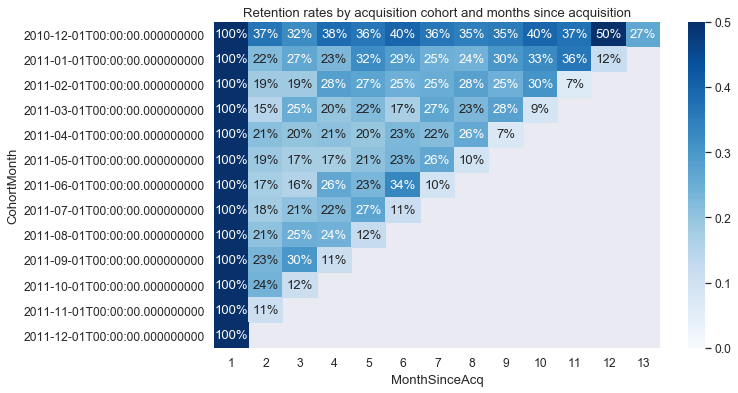

In [22]:
sns.set_style('whitegrid')
sns.set(font_scale=1.1)

plt.figure(figsize=(10, 6))
plt.title('Retention rates by acquisition cohort and months since acquisition')
sns.heatmap(data = retention,
            annot = True,
            fmt = '.0%',
            vmin = 0,
            vmax = 0.5,
            cmap = 'Blues')
plt.show()

#### Recency, frequency, monetary value, and tenure calculation
Recency: days since last customer transaction
<br>Frequency: number of transactions in the last 12 months (12 months is often the norm in this type of analysis, but number of month can be arbitrarily chosen)
<br>Monetary value: totoal spend in the last 12 months
<br>Tenure: days since acquisition/first purchase

In [23]:
# create a column for date of acquisition for each customer
df['AcquisitionDate'] = df.groupby('CustomerID')['InvoiceDate'].transform('min')

In [24]:
# filter latest 12 months of data
min_date = max(df['InvoiceDate']) + relativedelta(months=-12)
df_sub = df[df['InvoiceDate'] >= min_date]

In [25]:
# have a column for spend - unit price * quantity
df_sub['Spend'] = df_sub['Quantity'] * df_sub['UnitPrice']

# create a hypothetical snapshot day, which is 1 day after the latest purchase as if the analysis is done
# right after the data is available
snapshot_date = max(df_sub['InvoiceDate']) + dt.timedelta(days=1)

C:\Users\nalgn\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
df_sub.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,MonthSinceAcq,AcquisitionDate,Spend
20240,538032,22669,RED BABY BUNTING,5,2010-12-09 12:59:00,2.95,14479,United Kingdom,2010-12-01,2010-12-01,1,2010-12-09 12:59:00,14.75
20241,538032,22465,HANGING METAL STAR LANTERN,12,2010-12-09 12:59:00,1.65,14479,United Kingdom,2010-12-01,2010-12-01,1,2010-12-09 12:59:00,19.80
20242,538032,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-09 12:59:00,2.95,14479,United Kingdom,2010-12-01,2010-12-01,1,2010-12-09 12:59:00,17.70
20243,538032,22727,ALARM CLOCK BAKELIKE RED,4,2010-12-09 12:59:00,3.75,14479,United Kingdom,2010-12-01,2010-12-01,1,2010-12-09 12:59:00,15.00
20244,538032,22726,ALARM CLOCK BAKELIKE GREEN,4,2010-12-09 12:59:00,3.75,14479,United Kingdom,2010-12-01,2010-12-01,1,2010-12-09 12:59:00,15.00


Calculate RFM values and tenure

In [27]:
# aggregate on customer level for RFM
df_rfm = df_sub.groupby('CustomerID').agg({'InvoiceDate': lambda x:(snapshot_date - x.max()).days, # days from last transaction to snapshot date
                                           'InvoiceNo': 'nunique',
                                           'Spend': 'sum',
                                           'AcquisitionDate': lambda x: (snapshot_date - x.min()).days}) # days from first acquisition
df_rfm.rename(columns = {'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'Spend': 'MonetaryValue',
                         'AcquisitionDate': 'Tenure'}, inplace=True)

In [28]:
df_rfm.head()

,Recency,Frequency,MonetaryValue,Tenure
CustomerID,,,,
12346,326,1,77183.60,326
12347,2,6,3598.21,367
12348,75,4,1797.24,358
12349,19,1,1757.55,19
12350,310,1,334.40,310


#### K-means clustering using RFM values

Explore and preprocess RFM data

In [29]:
df_rfm.describe()

,Recency,Frequency,MonetaryValue,Tenure
count,4269.000000,4269.000000,4269.000000,4269.000000
mean,88.043570,4.172406,2013.056928,220.927618
std,94.313556,7.417543,8789.371246,117.325965
min,1.000000,1.000000,3.750000,1.000000
25%,18.000000,1.000000,303.930000,110.000000
50%,50.000000,2.000000,661.320000,247.000000
75%,134.000000,5.000000,1638.470000,323.000000
max,365.000000,194.000000,280206.020000,374.000000


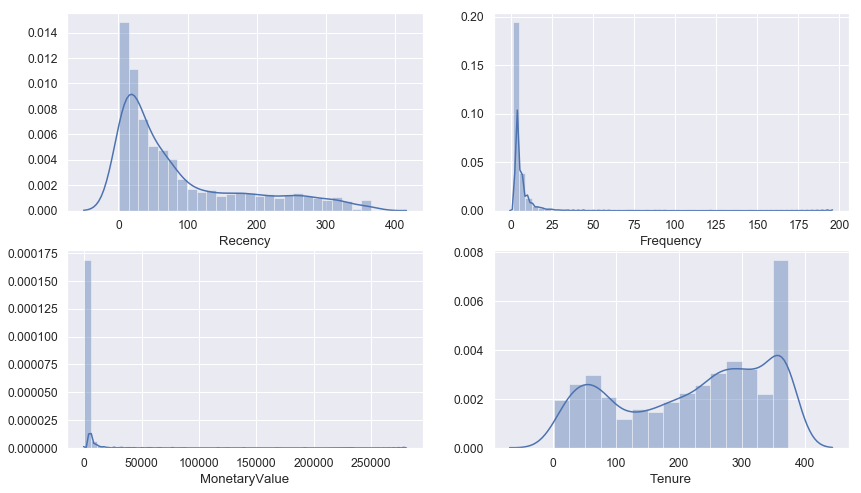

In [30]:
# histogram of RFM values
plt.figure(figsize=(14, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.distplot(df_rfm.iloc[:, i])
plt.show()

RFM values, particularly monetary value have a positive skew (the majority of customers have low frequency/monetary values); tenure has a negative skew. Will log transform the variables to make the distributions more normal.

In [31]:
# log transform RFM values
cols = ['Recency', 'Frequency', 'MonetaryValue', 'Tenure']
for col in cols:
    df_rfm[col+'Log'] = df_rfm[col].apply(lambda x: np.log(x))

In [32]:
df_rfm.head()

,Recency,Frequency,MonetaryValue,Tenure,RecencyLog,FrequencyLog,MonetaryValueLog,TenureLog
CustomerID,,,,,,,,
12346,326,1,77183.60,326,5.786897,0.000000,11.253942,5.786897
12347,2,6,3598.21,367,0.693147,1.791759,8.188192,5.905362
12348,75,4,1797.24,358,4.317488,1.386294,7.494007,5.880533
12349,19,1,1757.55,19,2.944439,0.000000,7.471676,2.944439
12350,310,1,334.40,310,5.736572,0.000000,5.812338,5.736572


Normalize log RFM values

In [33]:
# apply sklearn standardscaler
scaler = StandardScaler()
scaler.fit(df_rfm.iloc[:, -4:]) # last four columns
df_rfm_normalized = scaler.transform(df_rfm.iloc[:, -4:])

Running k-means clustering and choosing number of clusters

In [34]:
# function to fit k-means clustering for each of k chosen clusters (1 to k clusters) on a given array,
# returns sum of squared errors (sum of squared distances from data points to their cluster center) and labels
def run_kmeans(k, array):
    sse = {}
    labels = {}
    for i in range(1, k+1):
        kmeans = KMeans(n_clusters=i, random_state=1)
        kmeans.fit(array)
        sse[i] = kmeans.inertia_ 
        labels[i] = kmeans.labels_ # extract cluster lables
    return sse, labels

In [35]:
# run kmeans with 1 to 10 clusters 
sse, labels = run_kmeans(10, df_rfm_normalized)

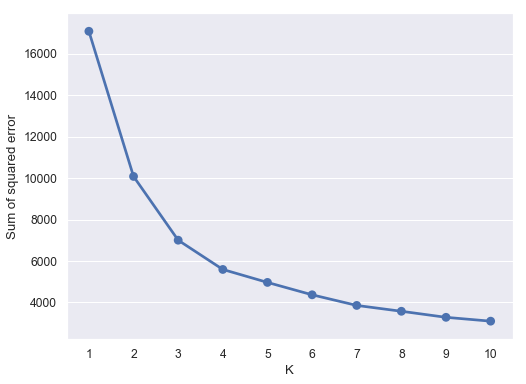

In [36]:
# plot sse as a function of k
plt.figure(figsize=(8, 6))
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.show()

The 'elbow' of the plot is around K=3 or 4. Will get cluster labels for kmeans with k=3/4 and look at RFM values of each cluster

Examine summary RFM and tenure of each cluster for 3-cluster and 4-cluster models

In [37]:
df_rfm['ClusterK3'] = labels[3]
summary_k3 = df_rfm.groupby('ClusterK3').agg({'Recency': 'mean',
                                              'Frequency': 'mean',
                                              'MonetaryValue': 'mean',
                                              'Tenure': ['mean', 'count']})
summary_k3

Recency Frequency MonetaryValue      Tenure      
                 mean      mean          mean        mean count
ClusterK3                                                      
0           37.133616  1.443266    496.260648   50.628844   943
1           27.104430  8.444304   4578.630064  287.743671  1580
2          170.684994  1.780641    510.613249  252.441008  1746

In [38]:
df_rfm['ClusterK4'] = labels[4]
summary_k4 = df_rfm.groupby('ClusterK4').agg({'Recency': 'mean',
                                              'Frequency': 'mean',
                                              'MonetaryValue': 'mean',
                                              'Tenure': ['mean', 'count']})
summary_k4

Recency  Frequency MonetaryValue      Tenure      
                 mean       mean          mean        mean count
ClusterK4                                                       
0           58.879636   3.794962   1490.762437  263.323303  1429
1           36.960541   1.395716    489.261331   47.342728   887
2          206.760528   1.346821    343.407110  245.393889  1211
3           11.520216  12.830189   7565.498235  306.854447   742

#### Interpreting segmentation results
Segmentation with 4 clusters appears to provide more insights into characteristics of customers. Below is the profile of each cluster:

__Cluster 0__: old customers who make purchases regularly but not too frequently
<br>__Cluster 1__: new customers who are beginning to use the site regularly
<br>__Cluster 2__: old customers who have not visited/purchased in a while and have churned or are at the risk of churing
<br>__Cluster 3__: oldest customers who frequently make purchases and contribute most to revenue

Different marketing strategies can then be used for different segments of customers, for example, sending reengagement emails or promotion code to customers who are at the risk of churning; predicting repurchase patterns of the oldest/most loyal customers and/or making it easier for them to repurchase; introducing new features/products to new customers.